In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/audeering/opensmile.git


Cloning into 'opensmile'...
remote: Enumerating objects: 1830, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1830 (delta 19), reused 15 (delta 15), pack-reused 1793 (from 2)
Receiving objects: 100% (1830/1830), 10.78 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (693/693), done.


In [3]:
%cd /content/opensmile

/content/opensmile


In [4]:
ls

buildAndroid.sh*         build.sh*       doc/             plugindev/
build_flags.ps1          CHANGELOG.md    example-audio/   progsrc/
build_flags.sh           cmake/          gradle/          README.md
buildIos.sh              CMakeLists.txt  LICENSE          scripts/
buildIosUniversalLib.sh  conanfile.py    licenses/        src/
build.ps1                config/         make_release.sh  test_package/


In [5]:
!bash build.sh

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to work with policies introduced by <max> or earlier.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Git: /usr/bin/git (found version "2.34.1")
CMake Deprecation Warning at src/newmat/CMakeLists.txt:2 (cmake_minimum_r

In [6]:
%cd /content/opensmile

/content/opensmile


In [7]:
import os, glob, subprocess, pandas as pd, numpy as np, tqdm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score


In [8]:
SPEECH_FILES_PTH = '/content/drive/MyDrive/hw3_speech_files/'
LABEL_CSV        = '/content/drive/MyDrive/hw3_outputs/labels.csv'
COLAB_DIR_PTH     = '/content/extracted'
IS09_CONF = '/content/opensmile/config/is09-13/IS09_emotion.conf'
SMIL_EXE  = '/content/opensmile/build/progsrc/smilextract/SMILExtract'

os.makedirs(COLAB_DIR_PTH,      exist_ok=True)
CSV_COLAB_PTH = f'{COLAB_DIR_PTH}/per_file_csv'
os.makedirs(CSV_COLAB_PTH,       exist_ok=True)
ALL_CSV  = f'{COLAB_DIR_PTH}/is09_all_speakers.csv'

In [9]:
#extract interspeech 2009 emotional challenge feature set
if not os.listdir(CSV_COLAB_PTH):
    wav_files = sorted(glob.glob(f'{SPEECH_FILES_PTH}/*.wav'))
    for wav in tqdm.tqdm(wav_files):
        base = os.path.basename(wav)[:-4]
        out  = f'{CSV_COLAB_PTH}/{base}.csv'
        inst = os.path.basename(wav)[:-4]
        cmd  = [
            SMIL_EXE,
            '-C', IS09_CONF,
            '-I', wav,
            '-csvoutput', out,
            '-instname', inst,
            '-nologfile', '1',
            '-noconsoleoutput', '1'
        ]
        subprocess.run(cmd, check=True)

100%|██████████| 2324/2324 [01:12<00:00, 32.14it/s]


In [10]:
import re
# create labels.csv
if not os.path.exists(LABEL_CSV):
    pat = re.compile(r'(?P<speaker>[a-z]{2})_\d{3}_(?P<emotion>[a-z-]+)_.*\.wav$', re.I)
    rows = []
    for wav in glob.glob(f'{SPEECH_FILES_PTH}/*.wav'):
        fname = os.path.basename(wav)
        m = pat.match(fname)
        if m:
            rows.append({'file': fname,
                         'speaker': m.group('speaker'),
                         'emotion': m.group('emotion')})
        else:
            print('no match:', fname)

    lbl_df = pd.DataFrame(rows).sort_values('file')
    os.makedirs(os.path.dirname(LABEL_CSV), exist_ok=True)
    lbl_df.to_csv(LABEL_CSV, index=False)
    print(f'{len(lbl_df)} rows in {LABEL_CSV}')
    print(lbl_df)
else:
    print('labels.csv exists')
    print(pd.read_csv(LABEL_CSV))

2324 rows in /content/drive/MyDrive/hw3_outputs/labels.csv
                                               file speaker  emotion
1782     cc_001_anxiety_910.77_May-twenty-third.wav      cc  anxiety
1916  cc_001_anxiety_916.11_Eight-hundred-eight.wav      cc  anxiety
1791  cc_001_anxiety_918.66_Eight-hundred-eight.wav      cc  anxiety
1692  cc_001_anxiety_928.48_Four-thousand-eight.wav      cc  anxiety
1796    cc_001_anxiety_934.73_Nine-thousand-six.wav      cc  anxiety
...                                             ...     ...      ...
2145      mm_001_shame_2878.13_six-hundred-nine.wav      mm    shame
2176      mm_001_shame_2883.75_six-hundred-nine.wav      mm    shame
2033   mm_001_shame_2889.69_ten-thousand-twelve.wav      mm    shame
2287   mm_001_shame_2895.38_ten-thousand-twelve.wav      mm    shame
2031      mm_001_shame_2901.30_two-hundred-four.wav      mm    shame

[2324 rows x 3 columns]


In [11]:
print('speakers:', sorted(lbl_df.speaker.unique()))
print('\nemotion counts:')
print(lbl_df.emotion.value_counts())

# confirm all .wav has a label
all_wavs   = set(os.path.basename(p) for p in glob.glob(f'{SPEECH_FILES_PTH}/*.wav'))
labeled    = set(lbl_df.file)
print('\n# of unlabeled wavs:', len(all_wavs - labeled))


speakers: ['cc', 'cl', 'gg', 'jg', 'mf', 'mk', 'mm']

emotion counts:
emotion
contempt      180
happy         177
interest      176
despair       174
disgust       172
anxiety       170
elation       159
boredom       154
cold-anger    154
sadness       151
pride         150
shame         148
panic         141
hot-anger     139
neutral        79
Name: count, dtype: int64

# of unlabeled wavs: 0


In [12]:
#combine csv files to one csv
from tqdm.auto import tqdm

if not os.path.exists(ALL_CSV):
    rows = []
    for csv in tqdm(glob.glob(f'{CSV_COLAB_PTH}/*.csv')):
        df = pd.read_csv(csv, sep=';')
        df['file'] = os.path.basename(csv).replace('.csv', '.wav')
        rows.append(df)

    feat_df = pd.concat(rows, ignore_index=True)
    meta = pd.read_csv(LABEL_CSV)
    feat_df  = feat_df.merge(meta, on='file', how='left')
    feat_df.to_csv(ALL_CSV, index=False)
    print(f'combined features saved in {ALL_CSV}')
else:
    feat_df = pd.read_csv(ALL_CSV)
    print(f'{ALL_CSV} exists')

  0%|          | 0/2324 [00:00<?, ?it/s]

combined features saved in /content/extracted/is09_all_speakers.csv


In [13]:
print(f'shape of combined features csv (is09_all_speakers.csv): {feat_df.shape}')

shape of combined features csv (is09_all_speakers.csv): (2324, 389)


In [14]:
print(f'columns of is09_all_speakers.csv: {feat_df.columns}')

columns of is09_all_speakers.csv: Index(['name', 'frameTime', 'pcm_RMSenergy_sma_max', 'pcm_RMSenergy_sma_min',
       'pcm_RMSenergy_sma_range', 'pcm_RMSenergy_sma_maxPos',
       'pcm_RMSenergy_sma_minPos', 'pcm_RMSenergy_sma_amean',
       'pcm_RMSenergy_sma_linregc1', 'pcm_RMSenergy_sma_linregc2',
       ...
       'F0_sma_de_amean', 'F0_sma_de_linregc1', 'F0_sma_de_linregc2',
       'F0_sma_de_linregerrQ', 'F0_sma_de_stddev', 'F0_sma_de_skewness',
       'F0_sma_de_kurtosis', 'file', 'speaker', 'emotion'],
      dtype='object', length=389)


In [15]:
print(f'first 10 rows\n: {feat_df.head(10)}')

first 10 rows
:                                             name  frameTime  \
0     'gg_001_shame_2048.25_Ten-thousand-twelve'        0.0   
1   'mf_001_boredom_3041.49_Three-thousand-five'        0.0   
2  'mm_001_anxiety_1306.80_three-thousand-eight'        0.0   
3                'cl_001_sadness_712.80_January'        0.0   
4    'cl_001_boredom_1108.66_Eight-hundred-five'        0.0   
5      'gg_001_pride_2160.01_March-twenty-fifth'        0.0   
6           'cl_001_happy_892.14_December-sixth'        0.0   
7    'gg_001_anxiety_824.23_Eight-hundred-eight'        0.0   
8        'cl_001_elation_828.41_September-fifth'        0.0   
9       'mk_001_sadness_1590.89_One-hundred-six'        0.0   

   pcm_RMSenergy_sma_max  pcm_RMSenergy_sma_min  pcm_RMSenergy_sma_range  \
0               0.071346               0.000625                 0.070721   
1               0.019240               0.000681                 0.018560   
2               0.057650               0.000165               

## Z-score Normalization

In [16]:
# count zeros in each feature column
meta_cols = ['file', 'speaker', 'emotion', 'name']
feat_cols = [c for c in feat_df.columns if c not in meta_cols]

zero_counts = (feat_df[feat_cols] == 0).sum()
zero_counts = zero_counts[zero_counts > 0].sort_values(ascending=False)

print("columns containing 0:\n")
for col, n in zero_counts.items():
    print(f"{col:<40s} {n:>6d}")

columns containing 0:

frameTime                                  2324
F0_sma_min                                 2324
F0_sma_minPos                              2316
F0_sma_de_amean                             436
F0_sma_de_min                               364
F0_sma_de_minPos                            364
F0_sma_kurtosis                             363
F0_sma_de_kurtosis                          363
F0_sma_de_max                               363
F0_sma_linregc1                             363
F0_sma_range                                363
F0_sma_maxPos                               363
F0_sma_skewness                             363
F0_sma_de_range                             363
F0_sma_de_maxPos                            363
F0_sma_stddev                               363
F0_sma_linregerrQ                           363
F0_sma_max                                  363
F0_sma_linregc2                             363
F0_sma_amean                                363
F0_sma_de_skewnes

In [17]:
# columns containing constant values
meta_cols  = ['file', 'speaker', 'emotion', 'name']
const_cols = [c for c in feat_df.columns
              if c not in meta_cols and feat_df[c].nunique(dropna=False) == 1]

print(f"\n{len(const_cols)} constant columns:")
print(const_cols)

display(feat_df[const_cols].describe().T[['min','max','mean']])



2 constant columns:
['frameTime', 'F0_sma_min']


,min,max,mean
frameTime,0.0,0.0,0.0
F0_sma_min,0.0,0.0,0.0


In [18]:
#Drop constant columns
feat_df = feat_df.drop(columns=const_cols)
print(f"Dropped constant columns {const_cols}. New shape = {feat_df.shape}")


Dropped constant columns ['frameTime', 'F0_sma_min']. New shape = (2324, 387)


In [19]:
#Drop F0_sma_minPos --> 2316 0s (almost always 0)

feat_df = feat_df.drop(columns=['F0_sma_minPos'])
print(f"Dropped F0_sma_minPos. New shape = {feat_df.shape}")

Dropped F0_sma_minPos. New shape = (2324, 386)


In [20]:
#get numeric columns for normalization
feat_cols = feat_df.select_dtypes(include=[np.number]).columns
print(f'{len(feat_cols)} numeric columns')

382 numeric columns


In [21]:
means = feat_df.groupby('speaker')[feat_cols].transform('mean')
stds  = feat_df.groupby('speaker')[feat_cols].transform('std', ddof=0)

# z-score normalise
feat_df[feat_cols] = (feat_df[feat_cols] - means) / stds

In [22]:
check = feat_df.groupby('speaker')[feat_cols].agg(['mean','std']).round(3)
print(check)


        pcm_RMSenergy_sma_max        pcm_RMSenergy_sma_min         \
                         mean    std                  mean    std   
speaker                                                             
cc                        0.0  1.002                   0.0  1.002   
cl                       -0.0  1.001                   0.0  1.001   
gg                        0.0  1.001                  -0.0  1.001   
jg                        0.0  1.002                   0.0  1.002   
mf                       -0.0  1.002                   0.0  1.002   
mk                       -0.0  1.001                  -0.0  1.001   
mm                       -0.0  1.002                  -0.0  1.002   

        pcm_RMSenergy_sma_range        pcm_RMSenergy_sma_maxPos         \
                           mean    std                     mean    std   
speaker                                                                  
cc                         -0.0  1.002                     -0.0  1.002   
cl           

In [23]:
print(f'first 10 rows\n: {feat_df.head(10)}')

first 10 rows
:                                             name  pcm_RMSenergy_sma_max  \
0     'gg_001_shame_2048.25_Ten-thousand-twelve'               0.363608   
1   'mf_001_boredom_3041.49_Three-thousand-five'              -0.462185   
2  'mm_001_anxiety_1306.80_three-thousand-eight'               0.418096   
3                'cl_001_sadness_712.80_January'              -0.101362   
4    'cl_001_boredom_1108.66_Eight-hundred-five'              -0.709757   
5      'gg_001_pride_2160.01_March-twenty-fifth'              -1.093733   
6           'cl_001_happy_892.14_December-sixth'              -0.315290   
7    'gg_001_anxiety_824.23_Eight-hundred-eight'              -1.245254   
8        'cl_001_elation_828.41_September-fifth'               1.813623   
9       'mk_001_sadness_1590.89_One-hundred-six'              -0.191756   

   pcm_RMSenergy_sma_min  pcm_RMSenergy_sma_range  pcm_RMSenergy_sma_maxPos  \
0               1.241181                 0.353870                 -1.077125   


# Training


In [76]:
# Columns with NaNs
nan_counts = feat_df.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)

display(nan_counts)


,0


In [83]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [84]:
# label encoder for emotion
le = LabelEncoder()
feat_df['emo_id'] = le.fit_transform(feat_df['emotion'])
print("classes:", list(le.classes_))

classes: ['anxiety', 'boredom', 'cold-anger', 'contempt', 'despair', 'disgust', 'elation', 'happy', 'hot-anger', 'interest', 'neutral', 'panic', 'pride', 'sadness', 'shame']


In [85]:
meta_cols    = {'file', 'name', 'speaker', 'emotion', 'emo_id'}
feature_cols = [c for c in feat_df.columns if c not in meta_cols]

In [86]:
# leave one out evaluation function
def leave_one_out_evaluation(df: pd.DataFrame,
              Xcols: list[str],
              make_clf,
              y_col: str = 'emo_id'):

    per_speaker, tot_acc, tot_f1, tot_n = {}, 0.0, 0.0, 0
    for speaker in sorted(df.speaker.unique()):

        tr, te = df[df.speaker != speaker], df[df.speaker == speaker]

        clf = make_clf()
        clf.fit(tr[Xcols].values, tr[y_col].values)
        y_hat  = clf.predict(te[Xcols].values).copy()
        y_true = te[y_col].values.copy()
        n = len(y_true)
        acc = accuracy_score(y_true, y_hat)
        wf1 = f1_score(y_true, y_hat, average='weighted')

        # per speaker classification report
        rep = classification_report(le.inverse_transform(y_true),
                                    le.inverse_transform(y_hat),
                                    digits=3)

        per_speaker[speaker] = dict(
            n = n,
            acc = acc,
            f1 = wf1,
            y_true = y_true,
            y_pred = y_hat,
            report = rep
        )

        tot_acc += acc * n
        tot_f1 += wf1 * n
        tot_n += n

    per_speaker['aggregate'] = dict(acc=tot_acc/tot_n,
                                f1 =tot_f1/tot_n,
                                n =tot_n)
    return per_speaker

In [87]:
# rbf-svm classifier with random forest selector for feature ranking
def make_svm_with_forest_selection():
    forest = RandomForestClassifier(
                   n_estimators = 100,
                   class_weight = 'balanced',
                   random_state = 42,
                   n_jobs       = -1)

    selector = SelectFromModel(estimator = forest,
                               threshold = 'mean')

    svm = SVC(kernel='rbf', C=10, gamma='scale',
                   class_weight='balanced')

    return Pipeline([
        ('sel', selector),
        ('clf', svm)
    ])


In [88]:

results = leave_one_out_evaluation(feat_df, feature_cols, make_svm_with_forest_selection)

for speaker, info in results.items():
    if speaker == 'aggregate':
        continue
    print(f"\nreport for speaker: {speaker}")
    print(info['report'])

print("\naggregated results:")
print("accuracy = {acc:.3f}".format(acc=results['aggregate']['acc']))
print("weighted F1 = {f1:.3f}".format(f1=results['aggregate']['f1']))

# number of features kept at last fold
pipe_last = make_svm_with_forest_selection()
pipe_last.fit(feat_df[feature_cols], feat_df['emo_id'])
mask = pipe_last.named_steps['sel'].get_support()
print(f"\nkept {mask.sum()} / {len(mask)} features.")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


report for speaker: cc
              precision    recall  f1-score   support

     anxiety      0.071     0.200     0.105        10
     boredom      0.061     0.133     0.083        15
  cold-anger      0.071     0.067     0.069        15
    contempt      0.400     0.455     0.426        22
     despair      0.091     0.222     0.129         9
     disgust      0.400     0.258     0.314        31
     elation      0.250     0.438     0.318        16
       happy      0.286     0.261     0.273        23
   hot-anger      0.435     0.714     0.541        14
    interest      0.083     0.059     0.069        17
     neutral      0.286     0.111     0.160        18
       panic      0.455     0.278     0.345        18
       pride      0.444     0.174     0.250        23
     sadness      0.333     0.154     0.211        13
       shame      0.500     0.143     0.222        21

    accuracy                          0.245       265
   macro avg      0.278     0.244     0.234       265
we

# Confusion Matrix

best test speaker: mm 



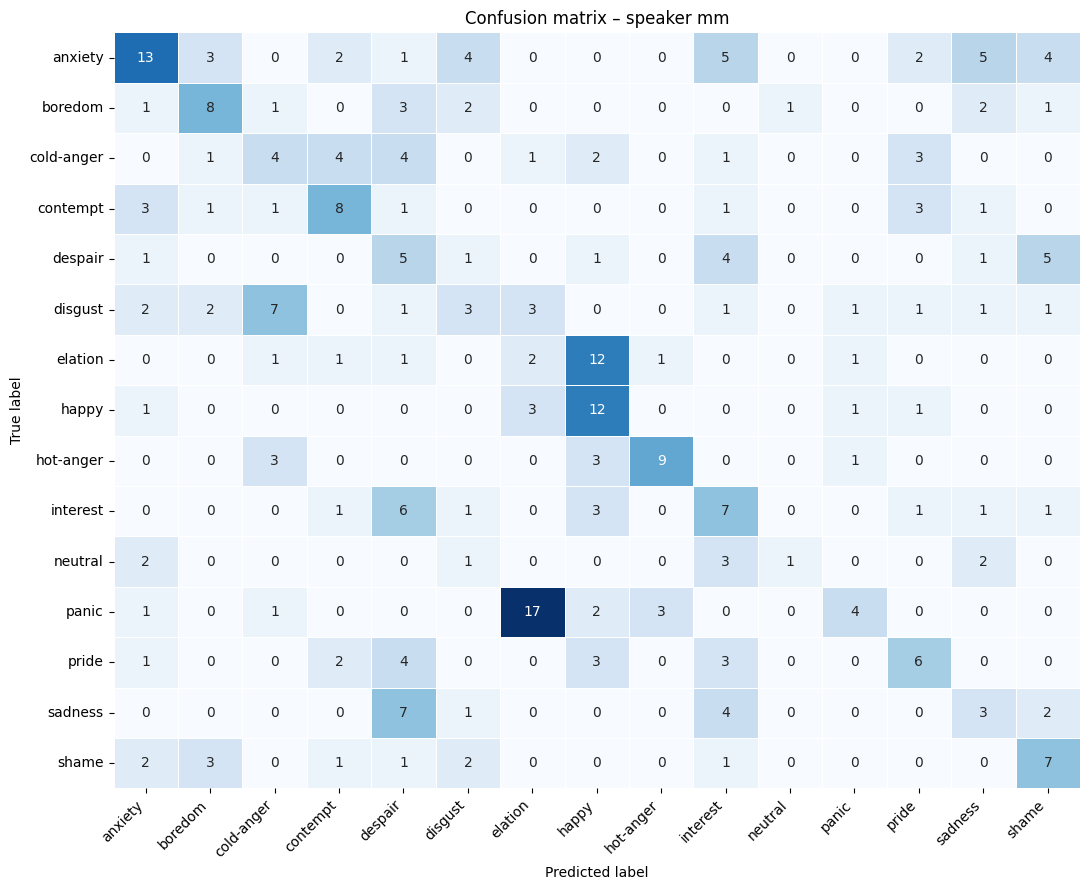


per-class metrics (speaker mm)



,precision,recall,f1,support,top 5 confusions:
anxiety,0.481,0.333,0.394,39,"interest, sadness, disgust, shame, boredom"
boredom,0.444,0.421,0.432,19,"despair, sadness, disgust, cold-anger, shame"
cold-anger,0.222,0.200,0.211,20,"contempt, despair, pride, happy, interest"
contempt,0.421,0.421,0.421,19,"anxiety, pride, cold-anger, despair, sadness"
despair,0.147,0.278,0.192,18,"shame, interest, anxiety, disgust, happy"
disgust,0.200,0.130,0.158,23,"cold-anger, elation, boredom, anxiety, sadness"
elation,0.077,0.105,0.089,19,"happy, panic, contempt, despair, hot-anger"
happy,0.316,0.667,0.429,18,"elation, pride, panic, anxiety"
hot-anger,0.692,0.562,0.621,16,"cold-anger, happy, panic"
interest,0.233,0.333,0.275,21,"despair, happy, pride, disgust, sadness"


Overall accuracy   : 0.304635761589404
Overall weighted F1: 0.303074163743047


In [92]:
# confusion matrix
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

best_spk = max((s for s in results if s != 'aggregate'),
               key=lambda s: results[s]['f1'])
print(f"best test speaker: {best_spk} \n")

y_true = results[best_spk]['y_true']
y_pred = results[best_spk]['y_pred']
labels = list(le.classes_)

cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
plt.figure(figsize=(11, 9))
sns.heatmap(cm, cmap='Blues', fmt='d', annot=True, xticklabels=labels, yticklabels=labels, cbar=False, linewidths=.4)
plt.title(f"Confusion matrix – speaker {best_spk}")
plt.xlabel("Predicted label"); plt.ylabel("True label")
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# per class
prec, rec, f1, supp = precision_recall_fscore_support(
                        y_true, y_pred, labels=range(len(labels)),
                        zero_division=0)
prf_df = pd.DataFrame({'precision': prec.round(3),
                       'recall'   : rec.round(3),
                       'f1'       : f1.round(3),
                       'support'  : supp},
                      index=labels)

# top 5 confusions
conf_top = []
for i, lab in enumerate(labels):
    top_idx = np.argsort(cm[i])[::-1]
    tops = [labels[j] for j in top_idx if j != i and cm[i, j] > 0][:5]
    conf_top.append(', '.join(tops) if tops else '—')
prf_df['top 5 confusions: '] = conf_top

print("\nper-class metrics (speaker %s)\n" % best_spk)
display(prf_df.style.format({'precision': '{:.3f}',
                             'recall':    '{:.3f}',
                             'f1':        '{:.3f}'}))

print("Overall accuracy   :", accuracy_score(y_true, y_pred))
print("Overall weighted F1:", results[best_spk]['f1'])

